In [49]:
import numpy as np
from numpy.random import binomial, normal, beta, multinomial
import scipy.stats as st
from scipy.stats import invwishart, norm, dirichlet, multivariate_normal
import matplotlib.pyplot as plt
from distcan import InverseGamma
from matplotlib.lines import Line2D
import math
import seaborn as sns
import pandas as pd

In [3]:
def data_gen(mu, cov, phi, n):
    """
    Generates samples from Mixture of K Multivariate Gaussian Distributions
    """

    y = np.empty((n, 2))
    for i in range(n):
        ind = multinomial(1, phi)
        for j, val in enumerate(ind):
            if val == 1:
                y[i,:] = np.random.multivariate_normal(mu[j,:], cov[j,:,:])
            else:
                next
    return np.array(y)

In [36]:
# Define parameters for K=3 Mixture of Multivariate Gaussians
phi = [.3, .5, .2]
mu = np.array([[3,5], [0,2], [-2,5]])
cov_1 = np.array([[2.0, 0.3], [0.3, 0.5]])
cov_2 = np.array([[3.0,.4], [.4,3.0]])    
cov_3 = np.array([[1.7,-1], [-.7,1.7]])
cov = np.stack((cov_1, cov_2, cov_3), axis = 0)


In [227]:
data = data_gen(mu, cov, phi, 500)
x, y = np.mgrid[-5:8:.1, -4:8:.1]
pos = np.dstack((x,y))



ValueError: mean must be 1 dimensional

In [228]:
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha = .6)
for i in range(len(mu)):
    ax.contour(x,y, multivariate_normal(mu[i,:], cov[i,:,:]).pdf(pos), extend='both')

fig.suptitle("K=3 Bivariate Gaussian Distributions Data")
ax.grid()
fig.show()

ValueError: Array 'mean' must be a vector of length 6.

## Prior Distributions

$$
\begin{align*}
p(\pmb{\pi}) & \sim Dir(\pmb{\alpha})\\
p(\pmb{\mu}_j|\Sigma_j) & \sim N(\pmb{\xi_j}, \frac{\Sigma_j}{\kappa_j})\\
p(\Sigma_j) & \sim W^{-1}(v_j, \Lambda^{-1}_j)\\
\end{align*}
$$

Our choice of prior distributions $p(\pmb{\mu}_j|\Sigma_j) \sim N(\pmb{\xi_j}, \frac{\Sigma_j}{\kappa_j})$ and 
$p(\Sigma_j) \sim W^{-1}(v_j, \Lambda^{-1}_j)$ is known as the normal-inverse-Wishart which is the conjugate prior to the multivariate normal distribution and parameterized by $(\pmb{\xi_j}, v_j, \Lambda_j, \kappa_j)$. The parameters $v_j$ and $\Lambda_j$ simply describe the degrees of freedom and the scale matrix for the inverse-Wishart distribution of $\Sigma_j$.

## Complete Conditional for $p(\pmb{\mu_j})$ and $p(\Sigma_j)$

We know from our last post that 
$$p(\theta|x,z) \propto p(x, z| \theta)p(\pmb{\pi})\prod_{j=1}^k\left[p(\pmb{\mu_j})p(\Sigma_j)\right]$$ 
and we can define the joint prior density

$$
\begin{align*}
p(\mu_j, \Sigma_j) & \propto \left|\Sigma_j\right|^{-\frac{v_j + d}{2+1}}\exp\left(\frac{1}{2}tr(\Lambda_j\Sigma_j^{-1})- \frac{\kappa_j}{2}(\mu_j - \xi_j)^T\Sigma_j^{-1}(\mu_j - \xi_j)\right)
\end{align*}
$$

which leads to the conditional density

$$
\begin{align*}
p(\mu_j, \Sigma_j | z, x, \pi) & \propto \prod_{i=1}^N\phi_{\theta_j}(x_i)^{z_j}\left|\Sigma_j\right|^{-\frac{v_j + d}{2+1}}\exp\left(\frac{1}{2}tr(\Lambda_j\Sigma_j^{-1})- \frac{\kappa_j}{2}(\mu_j - \xi_j)^T\Sigma_j^{-1}(\mu_j - \xi_j)\right)
\end{align*}
$$

This results in simply multiplying our joint prior density with a multivariate normal. Because of conjugacy, we know this results in a posterior density of the same family (normal inverse-Wishart) with parameters:

$$
\begin{align*}
\mu_n & = \frac{\kappa_j}{\kappa_j + n_j}\xi_j + \frac{n_j}{\kappa_j + n_j}\bar{y}\\
\kappa_n & = \kappa_j + n_j\\
v_n & = v_j + n_j\\
\Lambda_n & = \Lambda_j + \sum_{i=1}^N(x_i - \bar{x})(x_i - \bar{x})^T + \frac{n_j\kappa_j}{\kappa_j + n_j}(\bar{x} - \xi_j)(\bar{x} - \xi_j)^T
\end{align*}
$$

Samples from the joint conditional distribution $p(\mu_j, \Sigma_j | z, x, \pi)$ can be obtained by first sampling 
from $p(\Sigma_j) \sim W^{-1}(v_n, \Lambda_n)$, then sampling $p(\pmb{\mu}_j) \sim N(\pmb{\mu}_n, \frac{\Sigma_j}{\kappa_n})$


In [220]:
def update_pi(alpha_vec, z_mat):
    """
    Sample from Posterior Conditional for pi
    """
    n_j = np.sum(z_mat, axis=0)
    assert len(n_j) == len(alpha_vec), "Number of distributions must equal number of parameters"
    return dirichlet(n_j + alpha_vec).rvs()

def update_z(data, mu, cov, pi):
    """
    Sample from latent variable Z according to likelihoods for class assignment
    """
    a = np.empty((len(data), len(mu)))
    out = np.empty((len(data), len(mu)))
    for j in range(len(mu)):
        a[:,j] = multivariate_normal(mu[j], cov[j]).pdf(data) * pi[0,j]
    
    pi_i = a / np.sum(a, axis=1)[:,None]
    for i in range(len(data)):
        out[i,] = multinomial(1, pi_i[i,:])
    return out

def update_cov(data, z_mat, mu):
    """
    Sample from Posterior Conditional for sigma
    """
    n_j = np.sum(z_mat, axis=0)
    cov = []
    for j in range(len(mu)):
        y = data[z_mat[:,j] != 0, :]
        y_bar = y.mean(axis=0)
        s_squares = np.dot(np.transpose(y - y_bar), y - y_bar) + np.eye(2)
        cov.append(invwishart(n_j[j], s_squares).rvs())

    return cov

def update_mu(data, z_mat, cov):
    """
    Sample from Posterior Conditional for mu
    """
    mu = []
    n_j =  np.sum(z_mat, axis=0)
    for j in range(len(cov)):
        cov_j = cov[j] / n_j[j]
        y_bar = data[z_mat[:,j] != 0, :].mean(axis=0)
        sample = multivariate_normal(y_bar, cov_j).rvs()
        mu.append(sample)
    
    return mu

def gibbs(data, iters, burnin, k):
    """
    Run Gibb's Sampling for Mixture of k Bivariate Gaussians. Initial States are sampled from Priors
    """
    # Set initial guesses based on priors
    alpha = [1,1,1]
    mu = []
    cov = []
    for i in range(k):
        mu.append(multivariate_normal(np.zeros(2), np.eye(2)).rvs())
        cov.append(invwishart(2+1, np.eye(2)).rvs())

    pi = dirichlet(alpha).rvs()
    pi_out = np.empty((iters, k))
    mu_out = np.empty((iters, k, 2)) # Bivariate
    cov_out = np.empty((iters, k, 2, 2)) # Bivariate
    for i in range(iters):
        # Update Parameters according to conditional posterior distributions
        z_mat = update_z(data, mu, cov, pi)
        pi_new = update_pi(alpha, z_mat)
        mu_new = update_mu(data, z_mat, cov)
        cov_new = update_cov(data, z_mat, mu)
        # Store Values to monitor trace
        pi_out[i, :] = pi_new
        for j in range(k):
            mu_out[i, j :] = mu_new[j]
            cov_out[i, j, :, :] = cov_new[j]
    
    return pi_out[burnin:, :], mu_out[burnin:,:,:], cov_out[burnin:,:,:,:]


In [221]:
pi, mu, cov = gibbs(data, 5000, 2500, 3)
mu_fitted = mu.mean(axis = 0)
pi_fitted = pi.mean(axis = 0)
cov_fitted = cov.mean(axis = 0)

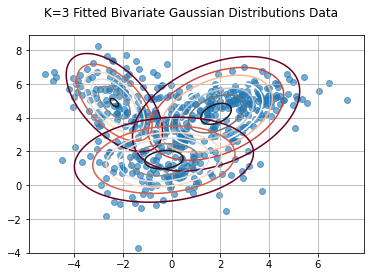

In [226]:
x, y = np.mgrid[-5:8:.1, -4:8:.1]
pos = np.dstack((x,y))
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha = .6)
for i in range(3):
    ax.contour(x,y, 
        multivariate_normal(mu_fitted[i,:], 
        cov_fitted[i,:,:]).pdf(pos), 
        extend='both',cmap='RdGy')

fig.suptitle("K=3 Fitted Bivariate Gaussian Distributions Data")
ax.grid()
fig.show()